# Wildfire Detection - by Selman Tabet @ https://selman.io/

### Importing Libraries

In [ ]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix

import seaborn as sns
from tensorflow.keras.utils import plot_model

### Environment Setup

In [13]:
DATASETS = {
    "dataset1": {
        "train": os.path.join("dataset1", "train"),
        "test": os.path.join("dataset1", "test"),
        "val": os.path.join("dataset1", "val")
    },
    "dataset2": {
        "train": os.path.join("dataset2", "Training and Validation"),
        "test": os.path.join("dataset2", "Testing")
    },
}
train_dirs = [DATASETS[dataset].get('train') for dataset in DATASETS]
test_dirs = [DATASETS[dataset].get('test') for dataset in DATASETS]
val_dirs = [DATASETS[dataset].get('val') for dataset in DATASETS]

print(DATASETS)
print(train_dirs)
print(test_dirs)
print(val_dirs)

{'dataset1': {'train': 'dataset1\\train', 'test': 'dataset1\\test', 'val': 'dataset1\\val'}, 'dataset2': {'train': 'dataset2\\Training and Validation', 'test': 'dataset2\\Testing'}}
['dataset1\\train', 'dataset2\\Training and Validation']
['dataset1\\test', 'dataset2\\Testing']
['dataset1\\val', None]


In [14]:
print(tf.config.get_visible_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


### Initialize data generators with augmentation

In [21]:
# ImageDataGenerator for original images (no augmentation)
original_datagen = ImageDataGenerator(rescale=1./255)

# ImageDataGenerator for augmented images
augmented_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [22]:
batch_size = 32
img_height, img_width = 224, 224  # ResNet50V2/EfficientNet expects 224x224 images

In [23]:
# Original images generator
original_train_generator = original_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    color_mode='rgb',
    shuffle=True
)

# Augmented images generator
augmented_train_generator = augmented_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    color_mode='rgb',
    shuffle=True
)


Found 3316 images belonging to 2 classes.
Found 3316 images belonging to 2 classes.


In [24]:

# Get class indices
class_indices = original_train_generator.class_indices
class_names = list(class_indices.keys())

# Get number of samples in each class for the original and augmented datasets
original_class_counts = {class_name: 0 for class_name in class_names}
augmented_class_counts = {class_name: 0 for class_name in class_names}

for class_name, class_index in class_indices.items():
    original_class_counts[class_name] = sum(original_train_generator.classes == class_index)
    augmented_class_counts[class_name] = sum(augmented_train_generator.classes == class_index)

# Print the results
print("Original Dataset Class Counts:")
for class_name, count in original_class_counts.items():
    print(f"{class_name}: {count}")

print("\nAugmented Dataset Class Counts:")
for class_name, count in augmented_class_counts.items():
    print(f"{class_name}: {count}")


Original Dataset Class Counts:
fire: 1658
nofire: 1658

Augmented Dataset Class Counts:
fire: 1658
nofire: 1658


In [25]:

# Function to create a tf.data.Dataset from ImageDataGenerator
def create_dataset(generator):
    dataset = tf.data.Dataset.from_generator(
        lambda: generator,
        output_types=(tf.float32, tf.float32),
        output_shapes=([None, img_height, img_width, 3], [None])
    )
    dataset = dataset.unbatch().batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

original_dataset = create_dataset(original_train_generator)
augmented_dataset = create_dataset(augmented_train_generator)

combined_train_dataset = original_dataset.concatenate(augmented_dataset)


### Training/Validation Split

In [26]:

# Calculate the number of samples in the training dataset
train_samples = original_train_generator.samples + augmented_train_generator.samples

# Calculate the number of batches for validation and training
val_size = int(0.2 * train_samples)
train_size = train_samples - val_size

# Split the combined dataset
val_dataset = combined_train_dataset.take(val_size)
train_dataset = combined_train_dataset.skip(val_size)

# Print the sizes of the datasets
print(f"Training dataset size: {train_size} samples")
print(f"Validation dataset size: {val_size} samples")


Training dataset size: 5306 samples
Validation dataset size: 1326 samples


In [27]:
# Print the number of samples in each dataset for each class
print("Number of samples in each dataset for each class:")

print("\nOriginal Dataset Class Counts:")
for class_name, count in original_class_counts.items():
    print(f"{class_name}: {count}")

print("\nAugmented Dataset Class Counts:")
for class_name, count in augmented_class_counts.items():
    print(f"{class_name}: {count}")

# Calculate and print the combined dataset class counts
combined_class_counts = {class_name: original_class_counts[class_name] + augmented_class_counts[class_name] for class_name in class_names}

print("\nCombined Dataset Class Counts:")
for class_name, count in combined_class_counts.items():
    print(f"{class_name}: {count}")

Number of samples in each dataset for each class:

Original Dataset Class Counts:
fire: 1658
nofire: 1658

Augmented Dataset Class Counts:
fire: 1658
nofire: 1658

Combined Dataset Class Counts:
fire: 3316
nofire: 3316


In [28]:
# Test data generator
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False
)

test_dataset = create_dataset(test_generator)

Found 362 images belonging to 2 classes.


In [29]:
# Get class indices
test_class_indices = test_generator.class_indices
test_class_names = list(test_class_indices.keys())

# Get number of samples in each class for the test dataset
test_class_counts = {class_name: 0 for class_name in test_class_names}

for class_name, class_index in test_class_indices.items():
    test_class_counts[class_name] = sum(test_generator.classes == class_index)

# Print the results
print("Test Dataset Class Counts:")
for class_name, count in test_class_counts.items():
    print(f"{class_name}: {count}")

Test Dataset Class Counts:
fire: 181
nofire: 181


### Data Visualization

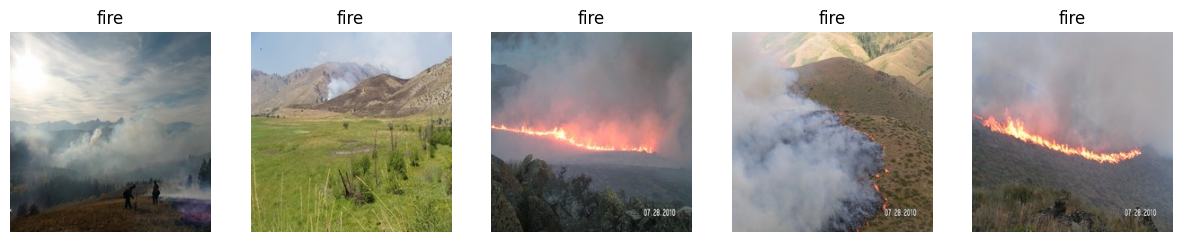

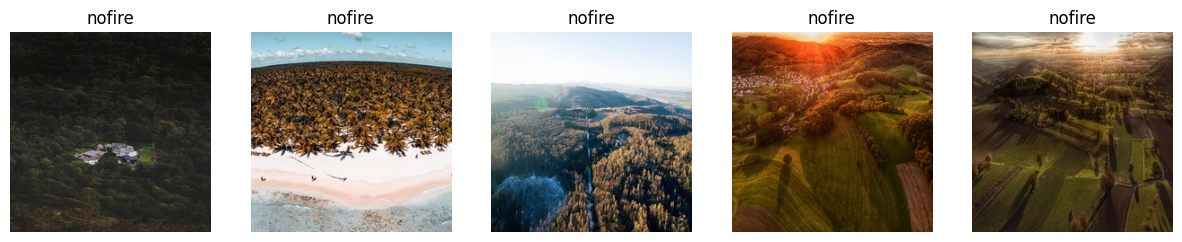

In [30]:
def plot_images(directory, category, num_images):
    category_dir = os.path.join(directory, category)
    images = os.listdir(category_dir)[:num_images]
    
    plt.figure(figsize=(15, 5))
    for i, img_name in enumerate(images):
        img_path = os.path.join(category_dir, img_name)
        img = load_img(img_path, target_size=(img_height, img_width))
        img_array = img_to_array(img) / 255.0
        
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img_array)
        plt.title(category)
        plt.axis('off')
    plt.show()

# Plotting 5 fire and 5 nofire images
plot_images(train_dir, 'fire', 5)
plot_images(train_dir, 'nofire', 5)


### Model Training

In [31]:
# Load the pre-trained ResNet50V2 model
base_model = ResNet50V2(
    include_top=False,
    weights='imagenet',
    input_shape=(img_height, img_width, 3)
)

base_model.trainable = False

callback = EarlyStopping(monitor='loss', patience=3)

# Create the model
inputs = Input(shape=(img_height, img_width, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,098,817 (91.93 MB)

 Trainable params: 529,409 (2.02 MB)

 Non-trainable params: 23,569,408 (89.91 MB)

### Pruning

In [32]:
# # Define the pruning parameters
# pruning_params = {
#     'pruning_schedule': sparsity.PolynomialDecay(initial_sparsity=0.0,
#                                                  final_sparsity=0.5,
#                                                  begin_step=0,
#                                                  end_step=1000)
# }

# # Wrap the model in a Sequential to make it compatible with pruning
# pruned_model = tf.keras.Sequential([model])
# pruned_model = sparsity.prune_low_magnitude(pruned_model, **pruning_params)

In [33]:

steps_per_epoch = train_size // batch_size
validation_steps = val_size // batch_size

In [ ]:

# Record the start time
start_time = time.time()

# Initial training
epochs = 50
history = model.fit(
    train_dataset,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=validation_steps,
    callbacks=[callback]
)


# Record the end time
end_time = time.time()

# Calculate the training time
training_time = end_time - start_time
print(f"Training time: {training_time:.2f} seconds")

Epoch 1/50


### Model Evaluation

In [1]:
print("Training data evaluation\n", model.evaluate(combined_train_dataset, steps=steps_per_epoch))
print("Test data evaluation\n", model.evaluate(test_dataset, steps=validation_steps))

NameError: name 'model' is not defined

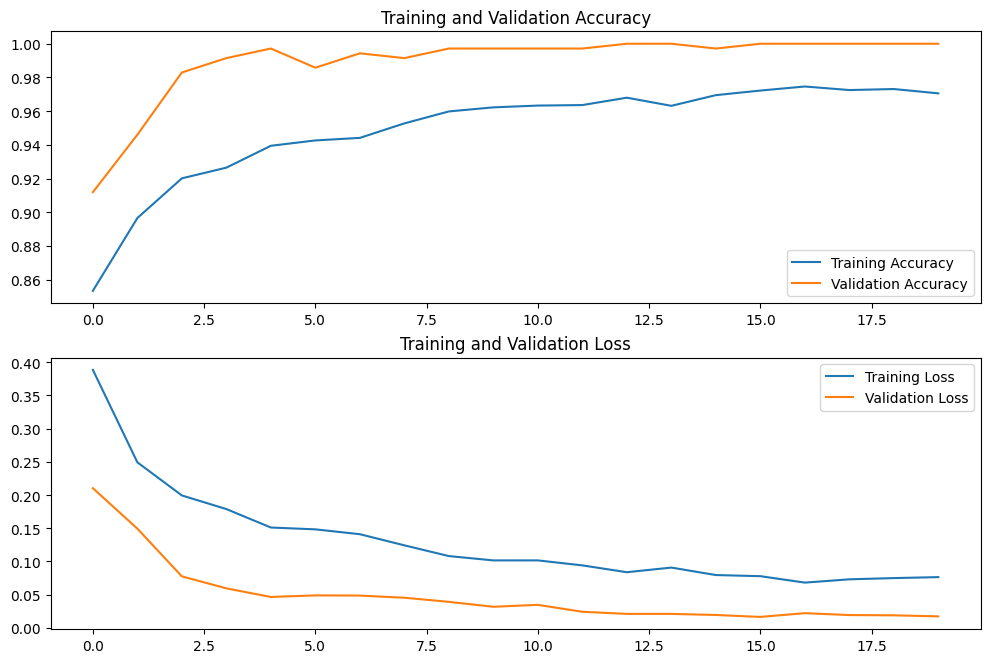

In [48]:
# Function to plot training history
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    # precision = history.history.get('precision', [])
    # val_precision = history.history.get('val_precision', [])
    epochs = range(len(acc))

    plt.figure(figsize=(12, 12))
    
    # Plot accuracy
    plt.subplot(3, 1, 1)
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(3, 1, 2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    # # Plot precision
    # plt.subplot(3, 1, 3)
    # plt.plot(epochs, precision, label='Training Precision')
    # plt.plot(epochs, val_precision, label='Validation Precision')
    # plt.title('Training and Validation Precision')
    # plt.legend()
    # plt.show()

plot_history(history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step


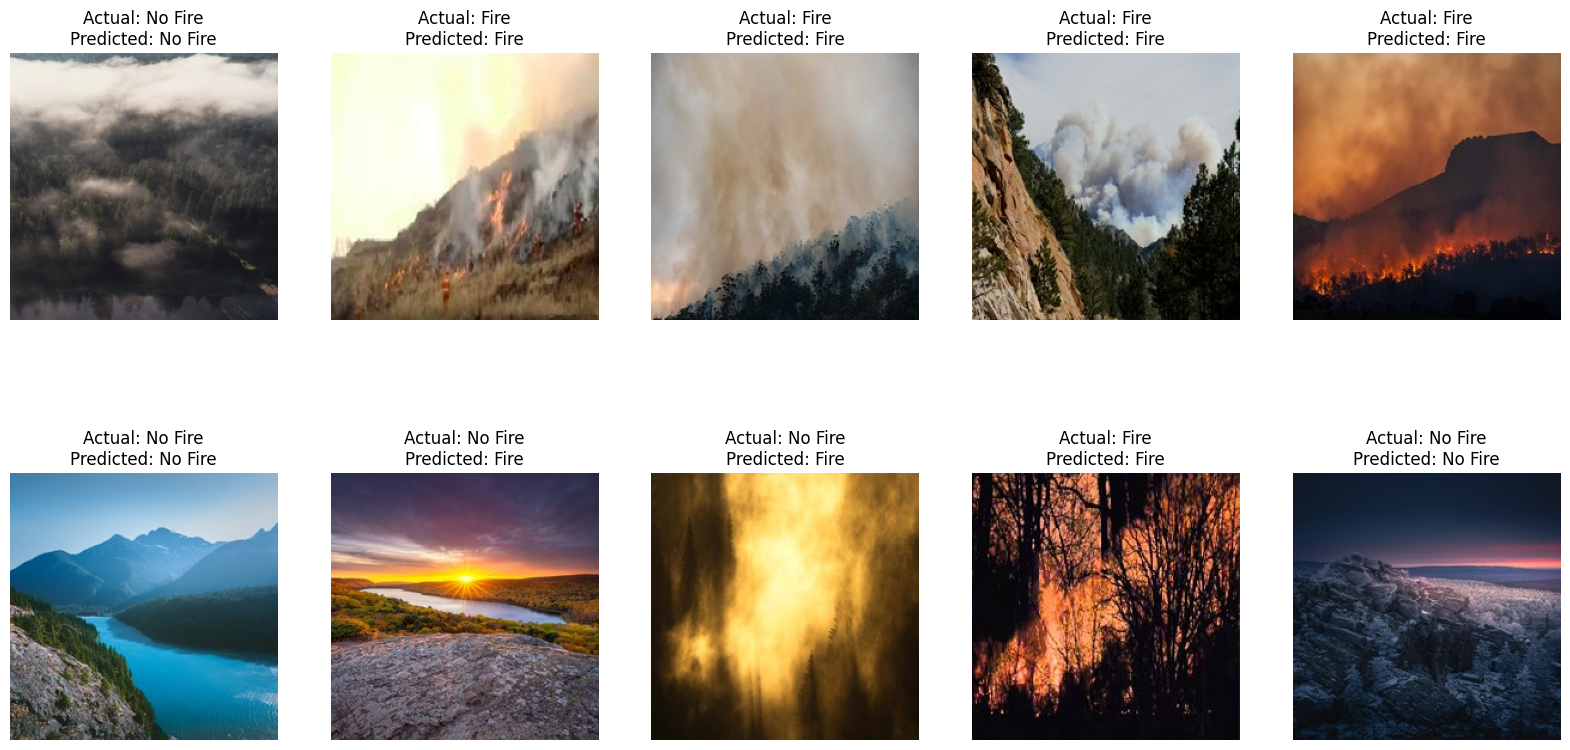

In [49]:
test_generator.reset()
while True:
    try:
        test_images, test_labels = next(test_generator)
        predictions = model.predict(test_images)

        fire_indices = np.where(test_labels == 1)[0]
        nofire_indices = np.where(test_labels == 0)[0]

        random_fire_indices = np.random.choice(fire_indices, 5, replace=False)
        random_nofire_indices = np.random.choice(nofire_indices, 5, replace=False)

        random_indices = np.concatenate((random_fire_indices, random_nofire_indices))
        np.random.shuffle(random_indices)

        # Plot the images with predictions
        plt.figure(figsize=(20, 10))
        for i, idx in enumerate(random_indices):
            plt.subplot(2, 5, i+1)
            plt.imshow(test_images[idx])
            plt.title(f"Actual: {'No Fire' if test_labels[idx] == 1 else 'Fire'}\nPredicted: {'No Fire' if predictions[idx] >= 0.5 else 'Fire'}")
            plt.axis('off')

        plt.show()
        break
        
    except ValueError:
        pass

> **NOTE:** Due to alphabetical order "Fire" is labelled as "0" and "No Fire" is labelled as "1"

### 50% Threshold

d:\Dissertation\Kaggle Data\Wildfire Combined\forest_fire\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 618ms/step


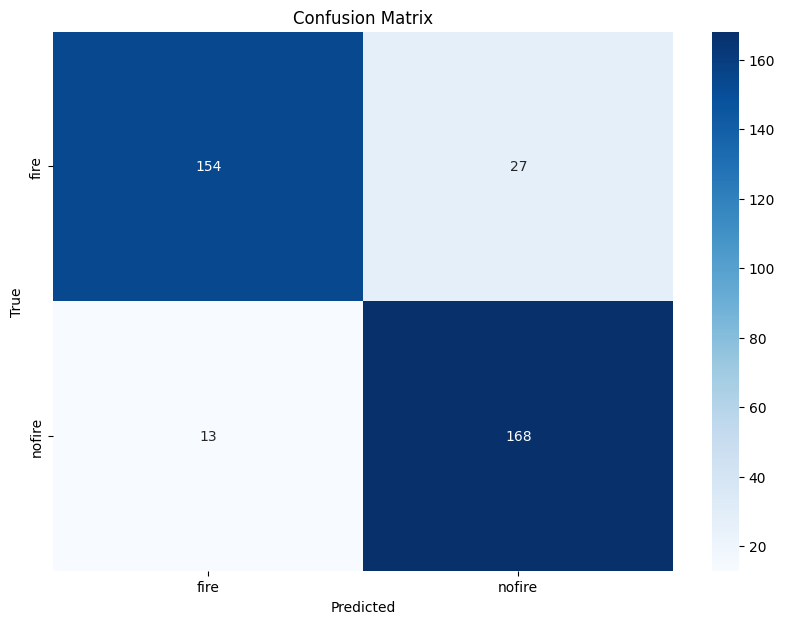

In [50]:

# Get the true labels and predicted labels
true_labels = test_generator.classes
predicted_labels = (model.predict(test_generator) >= 0.5).astype(int).flatten()

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Optimal Threshold

12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 528ms/step


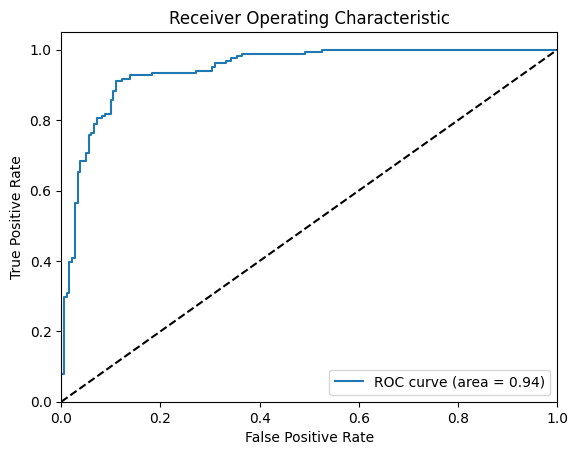

Optimal Threshold: 0.64908445


In [52]:
import numpy as np
from sklearn.metrics import roc_curve, auc


# Generate predictions on the validation set
# Generate predictions on the test set
y_pred_probs = model.predict(test_generator)

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(test_generator.classes, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Find the optimal threshold
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Optimal Threshold:", optimal_threshold)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


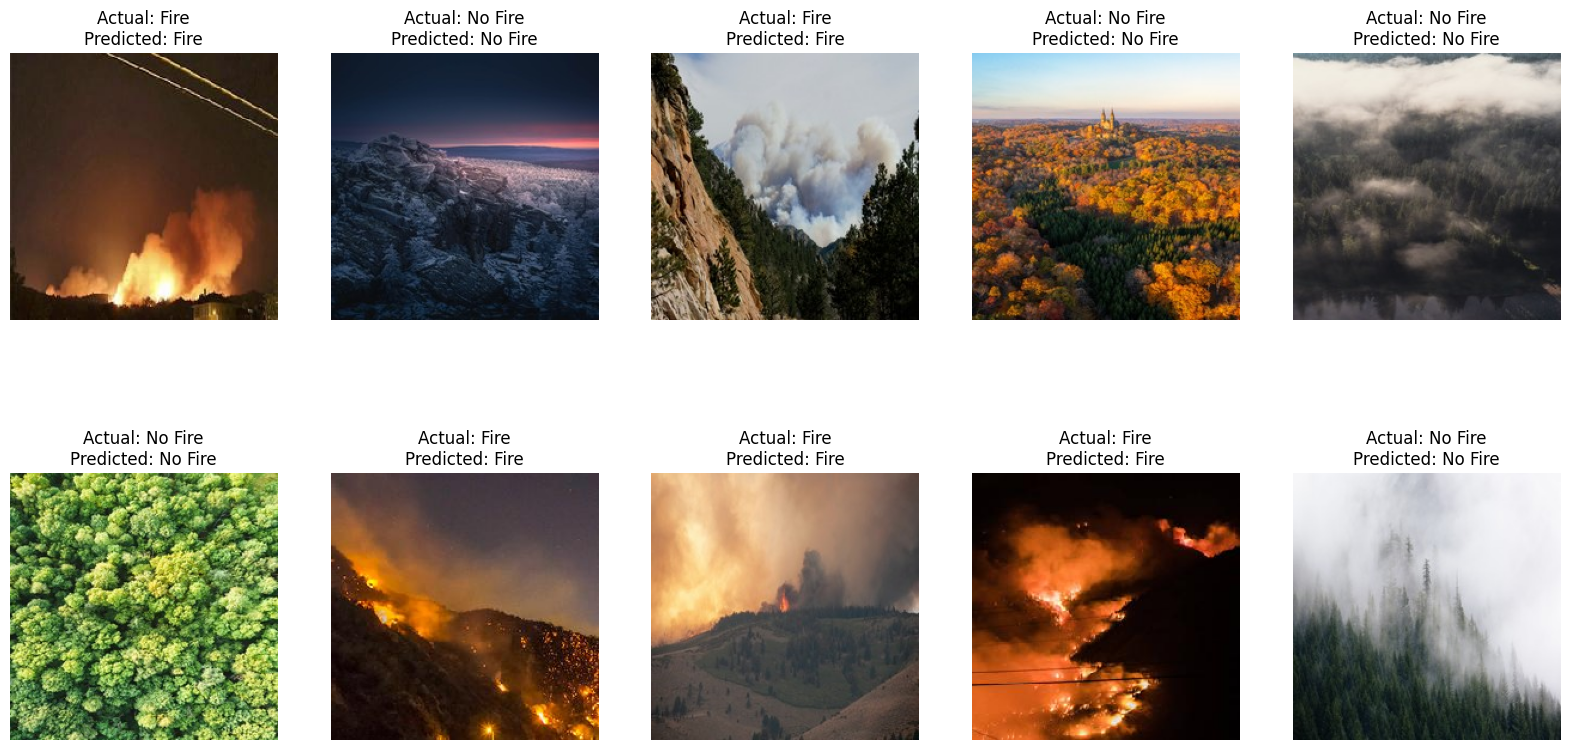

In [53]:
test_generator.reset()
while True:
    try:
        test_images, test_labels = next(test_generator)
        predictions = model.predict(test_images)

        fire_indices = np.where(test_labels == 1)[0]
        nofire_indices = np.where(test_labels == 0)[0]

        random_fire_indices = np.random.choice(fire_indices, 5, replace=False)
        random_nofire_indices = np.random.choice(nofire_indices, 5, replace=False)

        random_indices = np.concatenate((random_fire_indices, random_nofire_indices))
        np.random.shuffle(random_indices)

        # Plot the images with predictions
        plt.figure(figsize=(20, 10))
        for i, idx in enumerate(random_indices):
            plt.subplot(2, 5, i+1)
            plt.imshow(test_images[idx])
            plt.title(f"Actual: {'No Fire' if test_labels[idx] == 1 else 'Fire'}\nPredicted: {'No Fire' if predictions[idx] >= optimal_threshold else 'Fire'}")
            plt.axis('off')

        plt.show()
        break
        
    except ValueError:
        pass

12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 530ms/step


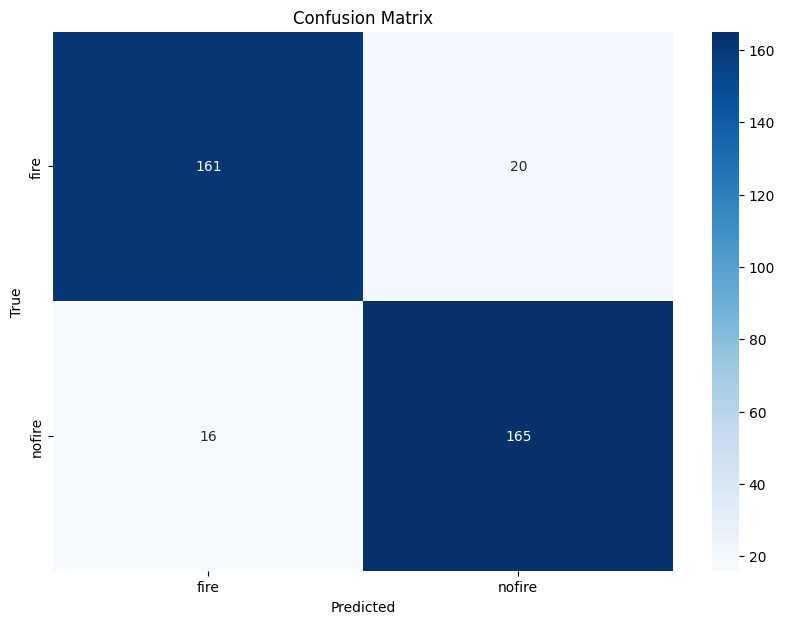

In [54]:

# Get the true labels and predicted labels
true_labels = test_generator.classes
predicted_labels = (model.predict(test_generator) >= optimal_threshold).astype(int).flatten()

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Save all files

In [ ]:
hist_df = pd.DataFrame(history.history) 
# Save the optimal threshold to a file
with open('optimal_threshold.txt', 'w') as f:
    f.write(str(optimal_threshold))

# Create directory structure
base_model_name = base_model.name
run_dirs = [d for d in os.listdir(base_model_name) if os.path.isdir(os.path.join(base_model_name, d)) and d.startswith('run_')]
run_number = len(run_dirs) + 1
run_dir = os.path.join(base_model_name, f'run_{run_number}')

os.makedirs(run_dir, exist_ok=True)

# Save the model, history, and optimal threshold in the new directory
model.save(os.path.join(run_dir, 'wildfire_detection_model.keras'))
hist_df.to_csv(os.path.join(run_dir, 'history.csv'), index=False)
with open(os.path.join(run_dir, 'optimal_threshold.txt'), 'w') as f:
    f.write(str(optimal_threshold))

# Save the confusion matrix plot
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig(os.path.join(run_dir, 'confusion_matrix.png'))
plt.close()

# Save the training/validation accuracy and loss graphs
plot_history(history)
plt.savefig(os.path.join(run_dir, 'training_validation_accuracy_loss.png'))
plt.close()


# Save the ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig(os.path.join(run_dir, 'roc_curve.png'))
plt.close()

# Visualize the model architecture
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

# Save the training time to a file
with open(os.path.join(run_dir, 'training_time.txt'), 'w') as f:
    f.write(f"{training_time:.6f}")